<a href="https://colab.research.google.com/github/warlords94/personal-coding/blob/main/ConvMixer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -U -q tensorflow-addons

     |████████████████████████████████| 1.1 MB 13.3 MB/s 


In [4]:
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt

import tensorflow_addons as tfa
import numpy as np
import tensorflow as tf

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 10

In [6]:
((x_train, y_train), (x_test,y_test)) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


In [7]:
val_split = 0.1

index1 = int((len(x_train))*0.1)

new_x_train, new_y_train = x_train[index1:] ,y_train[index1:]
x_val, y_val = x_train[:index1] , y_train[:index1]

print(f"Training data samples: {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")

Training data samples: 45000
Validation data samples: 5000
Test data samples: 10000


In [8]:
image_size =32
auto = tf.data.AUTOTUNE

data_augmentation = keras.Sequential([
                                      layers.RandomCrop(image_size,image_size) , layers.RandomFlip('horizontal'),
],name = 'data_augmentation')



In [9]:
def make_dataset(images, label,is_train = False):
  dataset = tf.data.Dataset.from_tensor_slices((images, label))
  print(dataset)
  if is_train:
    dataset = dataset.shuffle(1000).batch(batch_size).map( lambda x,y : (data_augmentation(x),y) , num_parallel_calls=auto)

    return dataset.prefetch(auto)

  

In [10]:
train_dataset = make_dataset(new_x_train ,new_y_train , is_train = True)
val_dataset = make_dataset(x_val, y_val )
test_dataset = make_dataset(x_test,y_test)

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.uint8, name=None))>
<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.uint8, name=None))>
<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.uint8, name=None))>


In [11]:
def activation_block(x):
  x = layers.Activation('gelu')(x)
  return layers.BatchNormalization()(x)

def conv_stem(x, filters:int , patch_size:int):
  x = layers.Conv2D(filters , kernel_size = patch_size , strides = patch_size )(x)
  return activation_block(x)


def conv_mixer_block(x, filter: int , kernel_size:int):
  x0 = x
  x =layers.DepthwiseConv2D(kernel_size = kernel_size , padding = 'same')(x)
  x = layers.Add()([activation_block(x),x0])

  x = layers.Conv2D(filter, kernel_size= 1)(x)
  x = activation_block(x)

  return x

def get_conv_mixer_256_8(image_size = 32, filters =256 ,depth = 8 , kernel_size=5, patch_size = 2, num_classes = 10):
  inputs = keras.Input((image_size,image_size,3))
  x = layers.Rescaling(scale = 1.0/255.0)(inputs)

  x = conv_stem(x,filters,patch_size)

  for _ in range(depth):
    x = conv_mixer_block(x,filters,kernel_size)

  x = layers.GlobalAvgPool2D()(x)
  outputs = layers.Dense(num_classes, activation="softmax")(x)

  return keras.Model(inputs,outputs)



In [12]:
def run_experiment(model):
  optimizer = tfa.optimizers.AdamW(
      learning_rate = learning_rate , weight_decay = weight_decay
  )

  model.compile(optimizer = optimizer , loss = 'sparse_categorical_crossentropy' , metrics =  ['accuracy'])
  
  checkpoint_filepath = "/tmp/checkpoint"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

  history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

  model.load_weights(checkpoint_filepath)
  _, accuracy = model.evaluate(test_dataset)
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")

  return history, model

In [13]:
conv_mixer_model = get_conv_mixer_256_8()
history, conv_mixer_model = run_experiment(conv_mixer_model)

Epoch 1/10
352/352 [==============================] - 90s 210ms/step - loss: 1.2333 - accuracy: 0.5551
Epoch 2/10
352/352 [==============================] - 76s 217ms/step - loss: 0.7906 - accuracy: 0.7214
Epoch 3/10
352/352 [==============================] - 76s 217ms/step - loss: 0.6033 - accuracy: 0.7894
Epoch 4/10
352/352 [==============================] - 76s 217ms/step - loss: 0.4931 - accuracy: 0.8286
Epoch 5/10
352/352 [==============================] - 76s 217ms/step - loss: 0.4139 - accuracy: 0.8573
Epoch 6/10
352/352 [==============================] - 76s 217ms/step - loss: 0.3541 - accuracy: 0.8792
Epoch 7/10
352/352 [==============================] - 77s 217ms/step - loss: 0.3006 - accuracy: 0.8962
Epoch 8/10
352/352 [==============================] - 77s 217ms/step - loss: 0.2636 - accuracy: 0.9099
Epoch 9/10
352/352 [==============================] - 76s 217ms/step - loss: 0.2384 - accuracy: 0.9181
Epoch 10/10
352/352 [==============================] - 77s 217ms/step - l

NotFoundError: ignored

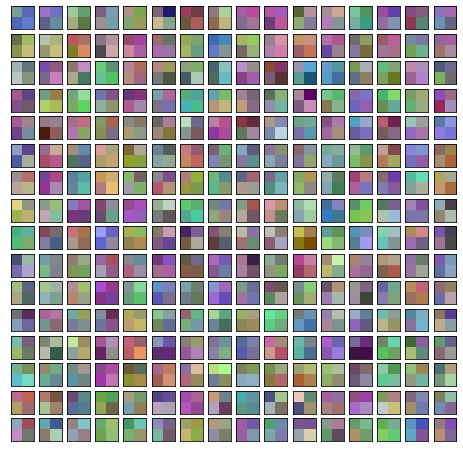

In [14]:
def visualization_plot(weights, idx =1):
  p_min , p_max = weights.min() , weights.max()
  weights = (weights - p_min) / (p_max - p_min)

  num_filters = 256
  plt.figure(figsize=(8,8))

  for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        if current_weight.shape[-1] == 1:
            current_weight = current_weight.squeeze()
        ax = plt.subplot(16, 16, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight)
        idx += 1


patch_embeddings = conv_mixer_model.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)


5 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f0d104f9390>
12 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f0d10376c90>
19 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f0d10394690>
26 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f0d10349290>
33 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f0d10372290>
40 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f0d1031cc50>
47 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f0d10397510>
54 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f0d103094d0>


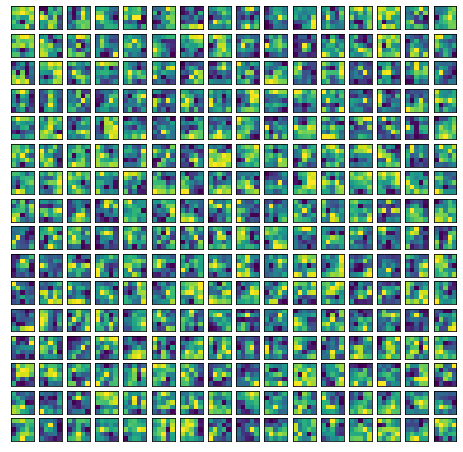

In [17]:
# First, print the indices of the convolution layers that are not
# pointwise convolutions.
for i, layer in enumerate(conv_mixer_model.layers):
    if isinstance(layer, layers.DepthwiseConv2D):
        if layer.get_config()["kernel_size"] == (5, 5):
            print(i, layer)

idx = 26  # Taking a kernel from the middle of the network.

kernel = conv_mixer_model.layers[idx].get_weights()[0]
kernel = np.expand_dims(kernel.squeeze(), axis=2)
visualization_plot(kernel)